Davies-Bouldin Index: 1.69


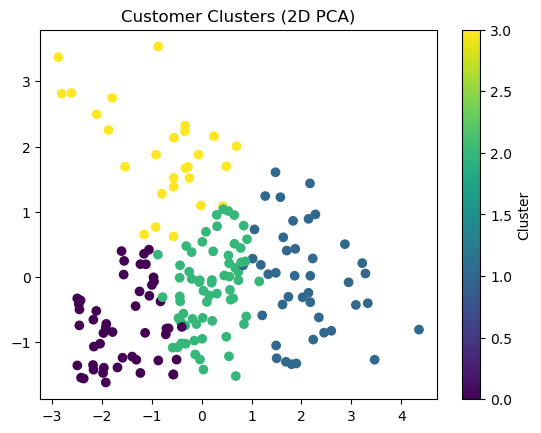

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Load raw data
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge data
merged_data = pd.merge(transactions, customers, on="CustomerID", how="left")
merged_data = pd.merge(merged_data, products, on="ProductID", how="left")

# Data cleaning (replicate Task 1 steps)
merged_data = merged_data.dropna(subset=["SignupDate", "TransactionDate"])
merged_data["SignupDate"] = pd.to_datetime(merged_data["SignupDate"])
merged_data["TransactionDate"] = pd.to_datetime(merged_data["TransactionDate"])
merged_data = merged_data[merged_data["TransactionDate"] >= merged_data["SignupDate"]]
merged_data = merged_data[(merged_data["TotalValue"] > 0) & (merged_data["Quantity"] > 0)]
merged_data = merged_data.drop_duplicates(subset=["TransactionID"])

# Feature Engineering for Clustering
# -----------------------------------
# 1. Recency (days since last transaction)
current_date = merged_data["TransactionDate"].max()
recency = merged_data.groupby("CustomerID")["TransactionDate"].max().reset_index()
recency["Recency"] = (current_date - recency["TransactionDate"]).dt.days

# 2. Frequency (total transactions)
frequency = merged_data.groupby("CustomerID")["TransactionID"].count().reset_index(name="Frequency")

# 3. Monetary (total spending)
monetary = merged_data.groupby("CustomerID")["TotalValue"].sum().reset_index(name="Monetary")

# 4. Tenure (days since signup)
tenure = merged_data.groupby("CustomerID")["SignupDate"].min().reset_index()
tenure["Tenure"] = (current_date - tenure["SignupDate"]).dt.days

# 5. Region & Favorite Category
region = merged_data[["CustomerID", "Region"]].drop_duplicates()
favorite_category = merged_data.groupby("CustomerID")["Category"].agg(lambda x: x.mode()[0]).reset_index()

# Combine all features
features = pd.merge(recency, frequency, on="CustomerID")
features = pd.merge(features, monetary, on="CustomerID")
features = pd.merge(features, tenure[["CustomerID", "Tenure"]], on="CustomerID")
features = pd.merge(features, region, on="CustomerID")
features = pd.merge(features, favorite_category, on="CustomerID")

# Preprocessing
# -------------
# Encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(features[["Region", "Category"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Region", "Category"]))

# Scale numerical features
scaler = StandardScaler()
numerical = features[["Recency", "Frequency", "Monetary", "Tenure"]]
scaled_numerical = scaler.fit_transform(numerical)
scaled_df = pd.DataFrame(scaled_numerical, columns=numerical.columns)

# Final dataset for clustering
final_data = pd.concat([features["CustomerID"], scaled_df, encoded_df], axis=1)

# Clustering with KMeans
# -----------------------
kmeans = KMeans(n_clusters=4, random_state=42)  # Choose based on elbow method
clusters = kmeans.fit_predict(final_data.drop("CustomerID", axis=1))

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(final_data.drop("CustomerID", axis=1), clusters)
print(f"Davies-Bouldin Index: {db_index:.2f}")

# Visualization using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(final_data.drop("CustomerID", axis=1))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="viridis")
plt.title("Customer Clusters (2D PCA)")
plt.colorbar(label="Cluster")
plt.show()

In [4]:
# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(features[["Region", "Category"]])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["Region", "Category"]))

# Scale numerical features
scaler = StandardScaler()
numerical_features = features[["Recency", "Frequency", "Monetary", "Tenure"]]
scaled_numerical = scaler.fit_transform(numerical_features)
scaled_df = pd.DataFrame(scaled_numerical, columns=numerical_features.columns)

# Combine all features
final_data = pd.concat([features["CustomerID"], scaled_df, encoded_df], axis=1)

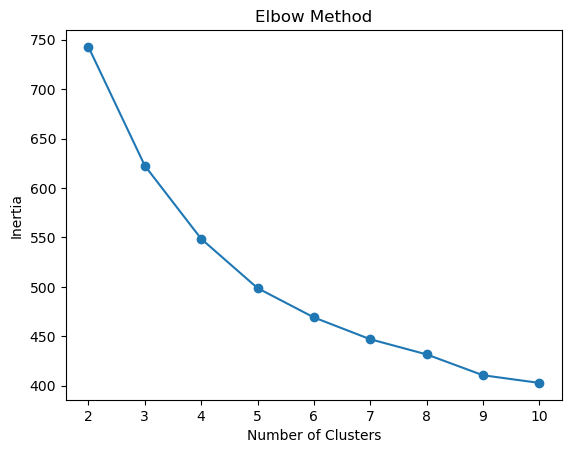

In [6]:
# Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_data.drop("CustomerID", axis=1))
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

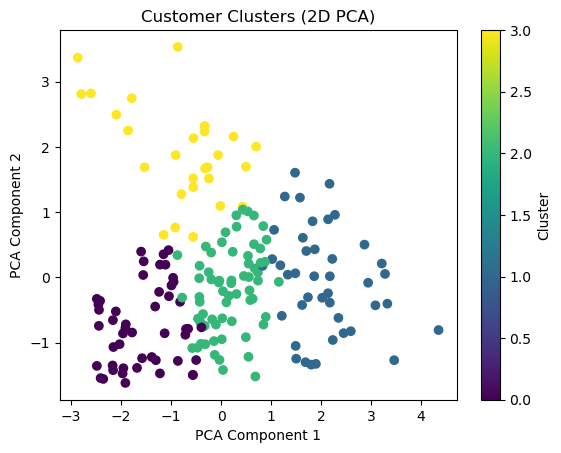

In [10]:
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(final_data.drop("CustomerID", axis=1))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Clusters (2D PCA)")
plt.colorbar(label="Cluster")
plt.show()